In [118]:
import torch
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import numpy
import pandas
from typing import Optional
from tqdm import tqdm
from torch.utils.data import random_split

In [119]:
class DropNorm(nn.Module):
	def __init__(self, size_in, size_out):
		super().__init__()

		self.size_in, self.size_out = size_in, size_out

		self.weights = nn.Parameter(torch.Tensor(size_out, size_in))  # nn.Parameter is a Tensor that's a module parameter.
		self.bias = nn.Parameter(torch.Tensor(size_out))

		self.linear1 = nn.Linear(size_in, size_out)
		self.activation = nn.ReLU(inplace=True) # inplace = don't use extra memory

		self.drop_probability = 0.5  # We can take as argument but this question doesn't requires it.
		
	
	def forward(self, batch):
		# First dim = batch size
		# Second dim = sample

		mu = batch.mean(dim=1) # Mean
		sigma = batch.std(dim=1) # Standard deviation
		epsilon = .00001 # To avoid division by zero
		A = torch.sqrt((sigma ** 2) + epsilon)

		# batch: [600, 2049]
		# mu: [600]
		# We need to substract mu from each dimension of batch.

		# (batch[0] - mu[0]) is like: [2049] - [1]

		#batch[0] = batch[0] - mu[0]
		#batch[1] = batch[1] - mu[1]
		# ...
		mu = torch.unsqueeze(mu, 1)
		B = batch - mu

		A = torch.unsqueeze(A, 1)
		new_x = B / A

		return new_x


# Defining the model

In [120]:
model = nn.Sequential(
	nn.Linear(784, 512),
	nn.ReLU(),

	# nn.BatchNorm2d(512),
	# nn.ReLU(),

	DropNorm(512, 512),
	nn.ReLU(),

	nn.Linear(512, 20),
	nn.Softmax()
)

In [121]:
BATCH_SIZE = 600
EPOCHS = 10
LR = 0.0001  # Learning rate

In [122]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: " + DEVICE)

Using device: cpu


In [123]:

dataset = torchvision.datasets.FashionMNIST(root="~/22961", train=True, download=True, transform=torchvision.transforms.PILToTensor())

train_dataset, test_dataset = random_split(dataset, [40000, 20000])
train_dataset, test_dataset = train_dataset.dataset, test_dataset.dataset

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

labels = train_dataset.classes

print("Labels: ", labels)

num_batches=len(train_dataloader)

Labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Loss, optimizer

In [124]:
loss_func=torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [125]:
def iterate_batch():
	imgs, labels = next(iter(train_dataloader))
	imgs = imgs.flatten(start_dim=1)

	optimizer.zero_grad()
	y_model=model(imgs.float())

	loss=loss_func(y_model,labels)
	loss.backward()
	optimizer.step()

	predicted_labels = y_model.argmax(dim=1)
	acc = (predicted_labels == labels).sum()/len(labels)
	return loss.detach(), acc.detach()

In [126]:
def iterate_epoch():
	running_loss=0.
	running_acc=0.
	for _ in range(num_batches):
		batch_loss, batch_acc = iterate_batch()
		running_loss += batch_loss
		running_acc +=  batch_acc
	loss=running_loss/num_batches
	acc=running_acc/num_batches
	return loss, acc

In [127]:
def eval_model_test():
  loss=0.
  acc=0.
  for imgs, labels in test_dataloader:
    imgs = imgs.flatten(start_dim=1)
    with torch.no_grad():
      y_model=model(imgs.float())
      loss += loss_func(y_model,labels)
      predicted_labels = y_model.argmax(dim=1)
      acc += (predicted_labels == labels).sum()/len(labels)
  return loss/num_batches, acc/num_batches

# Train and test the model

In [128]:
loss_train=torch.zeros(EPOCHS)
acc_train=torch.zeros(EPOCHS)
loss_test=torch.zeros(EPOCHS)
acc_test=torch.zeros(EPOCHS)

model[0].reset_parameters()
for epoch_idx in tqdm(range(EPOCHS)):
	loss_train[epoch_idx], acc_train[epoch_idx] = iterate_epoch()
	loss_test[epoch_idx], acc_test[epoch_idx] = eval_model_test()

  0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 10/10 [04:00<00:00, 24.02s/it]


Text(0.5, 0, 'Epoch Number')

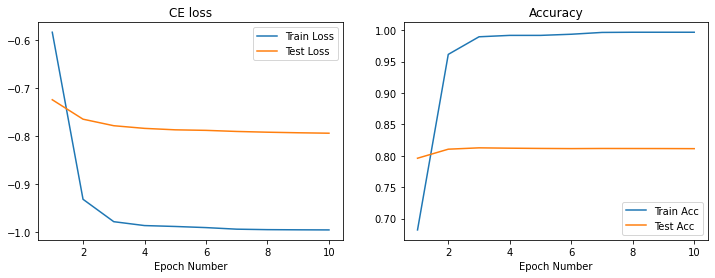

In [129]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1),loss_train,label="Train Loss")
plt.plot(range(1,EPOCHS+1),loss_test,label="Test Loss")
plt.title("CE loss")
plt.legend()
plt.xlabel("Epoch Number")
plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1),acc_train,label="Train Acc")
plt.plot(range(1,EPOCHS+1),acc_test,label="Test Acc")
plt.title("Accuracy")
plt.legend()
plt.xlabel("Epoch Number")